## Ungraded Lab: MNIST Autoencoder

You will now work on an autoencoder that works on the [MNIST dataset](https://www.tensorflow.org/datasets/catalog/mnist). This will encode the inputs to lower resolution images. The decoder should then be able to generate the original input from this compressed representation.

In [1]:
!pip install tensorflow_datasets

## Imports

In [2]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


## Prepare the Dataset

You will load the MNIST data from TFDS into train and test sets. Let's first define a preprocessing function for normalizing and flattening the images. Since we'll be training an autoencoder, this will return `image, image` because the input will also be the target or label while training.


In [3]:
def map_image(image, label):
  '''Normalizes and flattens the image. Returns image as input and label.'''
  image = tf.cast(image, dtype=tf.float32)
  image = image / 255.0
  image = tf.reshape(image, shape=(784,))

  return image, image

In [4]:
# Load the train and test sets from TFDS

BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 1024

train_dataset = tfds.load('mnist', as_supervised=True, split="train")
train_dataset = train_dataset.map(map_image)
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).repeat()

test_dataset = tfds.load('mnist', as_supervised=True, split="test")
test_dataset = test_dataset.map(map_image)
test_dataset = test_dataset.batch(BATCH_SIZE).repeat()

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


## Build the Model

You will now build a simple autoencoder to ingest the data. Like before, the encoder will compress the input and reconstructs it in the decoder output.

Saving auto.png to auto.png


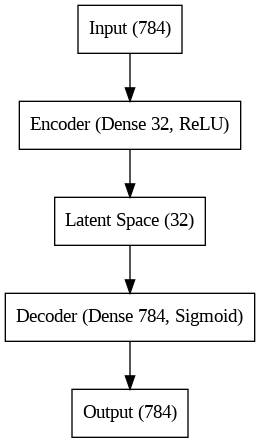

Uploaded image file: auto.png


In [5]:
from google.colab import files
from PIL import Image
import IPython.display as display
import io

uploaded = files.upload()

for file_name in uploaded.keys():

    image = Image.open(io.BytesIO(uploaded[file_name]))

    display.display(image)

    print(f"Uploaded image file: {file_name}")


In [7]:
def build_autoencoder():

    encoder_input = tf.keras.layers.Input(shape=(784,))
    x = tf.keras.layers.Dense(128, activation='relu')(encoder_input)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    encoder_output = tf.keras.layers.Dense(32, activation='relu')(x)

    encoder = tf.keras.models.Model(encoder_input, encoder_output, name='encoder')

    decoder_input = tf.keras.layers.Input(shape=(32,))
    x = tf.keras.layers.Dense(64, activation='relu')(decoder_input)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    decoder_output = tf.keras.layers.Dense(784, activation='sigmoid')(x)

    decoder = tf.keras.models.Model(decoder_input, decoder_output, name='decoder')

    autoencoder_input = tf.keras.layers.Input(shape=(784,))
    encoded = encoder(autoencoder_input)
    decoded = decoder(encoded)

    autoencoder = tf.keras.models.Model(autoencoder_input, decoded, name='autoencoder')

    return autoencoder, encoder, decoder

autoencoder, encoder, decoder = build_autoencoder()


## Compile the Model

You will setup the model for training. You can use binary crossentropy to measure the loss between pixel values that range from 0 (black) to 1 (white).

In [8]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


## Train the Model

In [11]:
steps_per_epoch = 60000 // BATCH_SIZE
validation_steps = 10000 // BATCH_SIZE

autoencoder.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    epochs=10,
    validation_data=test_dataset,
    validation_steps=validation_steps
)


Epoch 1/10
468/468 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.0134 - loss: 0.1163 - val_accuracy: 0.0085 - val_loss: 0.1084
Epoch 2/10
468/468 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.0111 - loss: 0.1084 - val_accuracy: 0.0127 - val_loss: 0.1032
Epoch 3/10
468/468 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.0126 - loss: 0.1040 - val_accuracy: 0.0128 - val_loss: 0.1008
Epoch 4/10
468/468 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.0122 - loss: 0.1013 - val_accuracy: 0.0121 - val_loss: 0.0984
Epoch 5/10
468/468 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.0132 - loss: 0.0991 - val_accuracy: 0.0112 - val_loss: 0.0963
Epoch 6/10
468/468 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.0137 - loss: 0.0969 - val_accuracy: 0.0105 - val_loss: 0.0948
Epoch 7/10
468/468 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.0129 - loss: 0.0951 - val_accuracy: 0.0149 - val_loss: 0.0930
Epoch 8/10
468/468 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.0133 - loss: 0.0936 - val_accuracy: 0.

## Display sample results

You can now visualize the results. The utility functions below will help in plotting the encoded and decoded values.

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


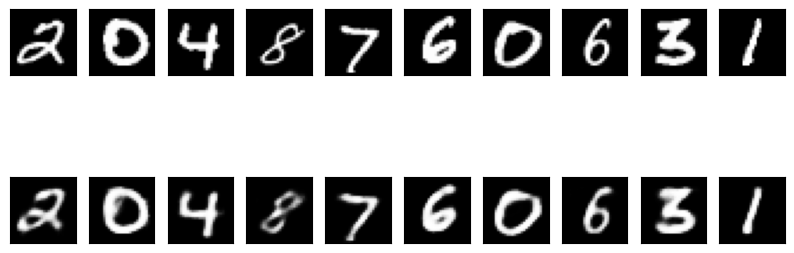

In [12]:
def display_results(autoencoder, test_dataset):
    for original, _ in test_dataset.take(1):
        encoded_imgs = encoder.predict(original)
        decoded_imgs = autoencoder.predict(original)

        plt.figure(figsize=(10, 4))
        for i in range(10):

            ax = plt.subplot(2, 10, i + 1)
            plt.imshow(original[i].numpy().reshape(28, 28), cmap='gray')
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

            ax = plt.subplot(2, 10, i + 11)
            plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
        plt.show()

display_results(autoencoder, test_dataset)


In [13]:
def display_one_row(disp_images, offset, shape=(28, 28)):
  '''Display sample outputs in one row.'''
  for idx, test_image in enumerate(disp_images):
    plt.subplot(3, 10, offset + idx + 1)
    plt.xticks([])
    plt.yticks([])
    test_image = np.reshape(test_image, shape)
    plt.imshow(test_image, cmap='gray')


def display_results(disp_input_images, disp_encoded, disp_predicted, enc_shape=(8,4)):
  '''Displays the input, encoded, and decoded output values.'''
  plt.figure(figsize=(15, 5))
  display_one_row(disp_input_images, 0, shape=(28,28,))
  display_one_row(disp_encoded, 10, shape=enc_shape)
  display_one_row(disp_predicted, 20, shape=(28,28,))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


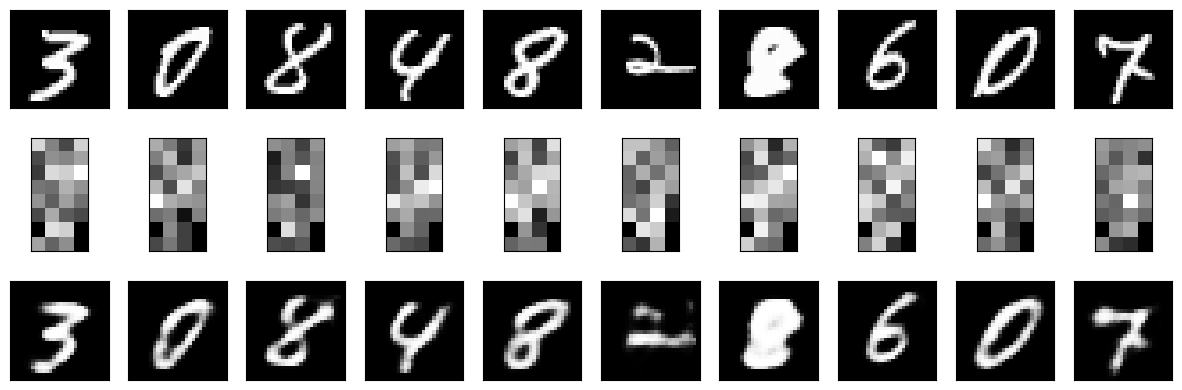

In [14]:
# take 1 batch of the dataset
test_dataset = test_dataset.take(1)

# take the input images and put them in a list
output_samples = []
for input_image, image in tfds.as_numpy(test_dataset):
      output_samples = input_image

# pick 10 random numbers to be used as indices to the list above
idxs = np.random.choice(BATCH_SIZE, size=10)

# get the encoder output
encoded_predicted = encoder.predict(test_dataset)

# get a prediction for the test batch
simple_predicted = autoencoder.predict(test_dataset)

# display the 10 samples, encodings and decoded values!
display_results(output_samples[idxs], encoded_predicted[idxs], simple_predicted[idxs])